# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from metrics import cohen_kappa_fn, f1_fn
from models import CustomClassifier1
from optim_utils import build_optimizer_and_scheduler
from torch import nn
from torchsummary import summary
from torchvision import transforms
from training import Trainer
from visualize import Visualizer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
import gc

def clean_memory():
    gc.collect()
    torch.cuda.empty_cache()

clean_memory()

In [4]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [5]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [6]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

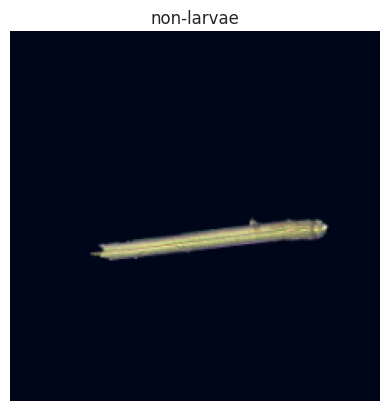

In [7]:
visualize_larvae_sample(train_loader.dataset)

In [8]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [9]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

optim_config = {
    "scheduler": "onecycle",
    "max_lr": 2e-4,
    "lr": 1e-4,
    "eta_min": 1e-6,
    "weight_decay": 1e-4,
    "warmup_epochs": 6,
}

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [10]:
cnn_0 = CustomClassifier1(
    input_shape=input_shape,
    num_classes=num_classes,
    device=device,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 224, 224]              16
            Conv2d-2          [-1, 4, 224, 224]              16
            Conv2d-3          [-1, 4, 224, 224]             148
            Conv2d-4          [-1, 4, 224, 224]              16
            Conv2d-5          [-1, 4, 224, 224]             404
         MaxPool2d-6          [-1, 3, 224, 224]               0
            Conv2d-7          [-1, 4, 224, 224]              16
       BatchNorm2d-8         [-1, 16, 224, 224]              32
    InceptionBlock-9         [-1, 16, 224, 224]               0
        MaxPool2d-10         [-1, 16, 112, 112]               0
           Conv2d-11         [-1, 32, 112, 112]           4,640
      BatchNorm2d-12         [-1, 32, 112, 112]              64
             ReLU-13         [-1, 32, 112, 112]               0
        MaxPool2d-14           [-1, 32,

In [11]:
optimizer_cnn_0, scheduler_cnn_0 = build_optimizer_and_scheduler(
    cnn_0,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=60,
)
ckpt_cnn_0 = "weights/larvae-adv-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=7,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [12]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=60)

📘 Epoch 1 | Train Loss: 0.6930 | Val Loss: 0.6930 | Train cohen_kappa_fn: 0.0354 | Val cohen_kappa_fn: 0.0283 | Train f1_fn: 0.3124 | Val f1_fn: 0.1570
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6922 | Val Loss: 0.6928 | Train cohen_kappa_fn: 0.0103 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.9095 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6913 | Val Loss: 0.6912 | Train cohen_kappa_fn: 0.1601 | Val cohen_kappa_fn: 0.1687 | Train f1_fn: 0.8240 | Val f1_fn: 0.8816
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6884 | Val Loss: 0.6881 | Train cohen_kappa_fn: 0.2030 | Val cohen_kappa_fn: 0.2131 | Train f1_fn: 0.7409 | Val f1_fn: 0.7478
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6855 | Val Loss: 0.6851 | Train cohen_kappa_fn: 0.1734 | Val cohen_kappa_fn: 0.0991 | Train f1_fn: 0.8798 | Val f1_fn: 0.9141
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6817 | Val Loss: 0.6802 | Train cohen_kappa_fn: 0.1995 | Val cohen_kappa_fn: 0.0631 | Train f1_fn: 0.9041 | Val f1_fn: 0.9107
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.6746 | Val Loss: 0.6700 | Train cohen_kappa_fn: 0.3274 | Val cohen_kappa_fn: 0.3404 | Train f1_fn: 0.8647 | Val f1_fn: 0.8821
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.6665 | Val Loss: 0.6564 | Train cohen_kappa_fn: 0.3461 | Val cohen_kappa_fn: 0.3742 | Train f1_fn: 0.8467 | Val f1_fn: 0.8679
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.6561 | Val Loss: 0.6480 | Train cohen_kappa_fn: 0.3924 | Val cohen_kappa_fn: 0.4074 | Train f1_fn: 0.8994 | Val f1_fn: 0.9074
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.6454 | Val Loss: 0.6290 | Train cohen_kappa_fn: 0.4499 | Val cohen_kappa_fn: 0.4029 | Train f1_fn: 0.8878 | Val f1_fn: 0.8863
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.6285 | Val Loss: 0.6150 | Train cohen_kappa_fn: 0.2742 | Val cohen_kappa_fn: 0.3488 | Train f1_fn: 0.7561 | Val f1_fn: 0.7956
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.6177 | Val Loss: 0.5927 | Train cohen_kappa_fn: 0.3445 | Val cohen_kappa_fn: 0.3875 | Train f1_fn: 0.8076 | Val f1_fn: 0.8248
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.6071 | Val Loss: 0.5699 | Train cohen_kappa_fn: 0.5334 | Val cohen_kappa_fn: 0.5719 | Train f1_fn: 0.9160 | Val f1_fn: 0.9311
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.5709 | Val Loss: 0.5545 | Train cohen_kappa_fn: 0.3547 | Val cohen_kappa_fn: 0.4145 | Train f1_fn: 0.8000 | Val f1_fn: 0.8276
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.5589 | Val Loss: 0.5176 | Train cohen_kappa_fn: 0.4531 | Val cohen_kappa_fn: 0.5666 | Train f1_fn: 0.8630 | Val f1_fn: 0.9069
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.5243 | Val Loss: 0.5147 | Train cohen_kappa_fn: 0.3260 | Val cohen_kappa_fn: 0.3768 | Train f1_fn: 0.7703 | Val f1_fn: 0.8044
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.4964 | Val Loss: 0.4496 | Train cohen_kappa_fn: 0.4865 | Val cohen_kappa_fn: 0.5690 | Train f1_fn: 0.8690 | Val f1_fn: 0.8988
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.4490 | Val Loss: 0.4479 | Train cohen_kappa_fn: 0.3564 | Val cohen_kappa_fn: 0.4509 | Train f1_fn: 0.7907 | Val f1_fn: 0.8475
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.4225 | Val Loss: 0.3913 | Train cohen_kappa_fn: 0.8078 | Val cohen_kappa_fn: 0.7526 | Train f1_fn: 0.9704 | Val f1_fn: 0.9655
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.4073 | Val Loss: 0.3663 | Train cohen_kappa_fn: 0.4227 | Val cohen_kappa_fn: 0.5287 | Train f1_fn: 0.8310 | Val f1_fn: 0.8884
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.3853 | Val Loss: 0.3558 | Train cohen_kappa_fn: 0.8387 | Val cohen_kappa_fn: 0.7373 | Train f1_fn: 0.9747 | Val f1_fn: 0.9638
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.3551 | Val Loss: 0.2793 | Train cohen_kappa_fn: 0.6630 | Val cohen_kappa_fn: 0.7447 | Train f1_fn: 0.9299 | Val f1_fn: 0.9544
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.3537 | Val Loss: 0.3175 | Train cohen_kappa_fn: 0.8750 | Val cohen_kappa_fn: 0.7826 | Train f1_fn: 0.9807 | Val f1_fn: 0.9690
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2832 | Val Loss: 0.2519 | Train cohen_kappa_fn: 0.7603 | Val cohen_kappa_fn: 0.7321 | Train f1_fn: 0.9544 | Val f1_fn: 0.9526
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.3077 | Val Loss: 0.2505 | Train cohen_kappa_fn: 0.8746 | Val cohen_kappa_fn: 0.8001 | Train f1_fn: 0.9789 | Val f1_fn: 0.9685
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.2791 | Val Loss: 0.2533 | Train cohen_kappa_fn: 0.8977 | Val cohen_kappa_fn: 0.8104 | Train f1_fn: 0.9836 | Val f1_fn: 0.9704
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.2817 | Val Loss: 0.4584 | Train cohen_kappa_fn: 0.2868 | Val cohen_kappa_fn: 0.2572 | Train f1_fn: 0.7257 | Val f1_fn: 0.6971
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.2808 | Val Loss: 0.3043 | Train cohen_kappa_fn: 0.9369 | Val cohen_kappa_fn: 0.7971 | Train f1_fn: 0.9904 | Val f1_fn: 0.9708
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.2266 | Val Loss: 0.1894 | Train cohen_kappa_fn: 0.8388 | Val cohen_kappa_fn: 0.8318 | Train f1_fn: 0.9719 | Val f1_fn: 0.9719
  🔥 New best model saved!


📘 Epoch 30 | Train Loss: 0.3277 | Val Loss: 0.1958 | Train cohen_kappa_fn: 0.8145 | Val cohen_kappa_fn: 0.7625 | Train f1_fn: 0.9664 | Val f1_fn: 0.9583
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.2750 | Val Loss: 0.5401 | Train cohen_kappa_fn: 0.6960 | Val cohen_kappa_fn: 0.6711 | Train f1_fn: 0.9613 | Val f1_fn: 0.9590
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.3074 | Val Loss: 0.2664 | Train cohen_kappa_fn: 0.9102 | Val cohen_kappa_fn: 0.8593 | Train f1_fn: 0.9859 | Val f1_fn: 0.9800
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.2866 | Val Loss: 0.2894 | Train cohen_kappa_fn: 0.4399 | Val cohen_kappa_fn: 0.4803 | Train f1_fn: 0.8375 | Val f1_fn: 0.8619
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.2674 | Val Loss: 0.7900 | Train cohen_kappa_fn: 0.0920 | Val cohen_kappa_fn: 0.1413 | Train f1_fn: 0.3967 | Val f1_fn: 0.5272
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.2676 | Val Loss: 0.2097 | Train cohen_kappa_fn: 0.8134 | Val cohen_kappa_fn: 0.8164 | Train f1_fn: 0.9664 | Val f1_fn: 0.9701
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.2542 | Val Loss: 0.2447 | Train cohen_kappa_fn: 0.8970 | Val cohen_kappa_fn: 0.7969 | Train f1_fn: 0.9836 | Val f1_fn: 0.9686
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


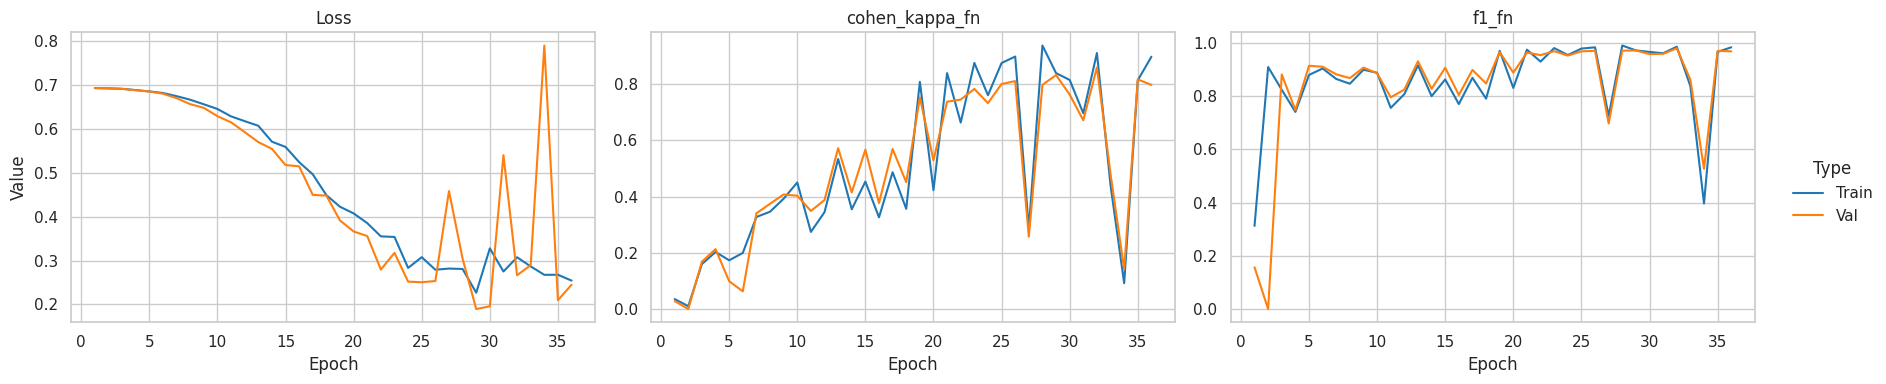

In [13]:
trainer_cnn_0.plot_epochs()

In [14]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2017 | Test cohen_kappa_fn: 0.8619 | Test f1_fn: 0.9791


#### Visualization

In [15]:
visualizer_0 = Visualizer(model=trainer_cnn_0.model, device=device, labels_map=labels_map)

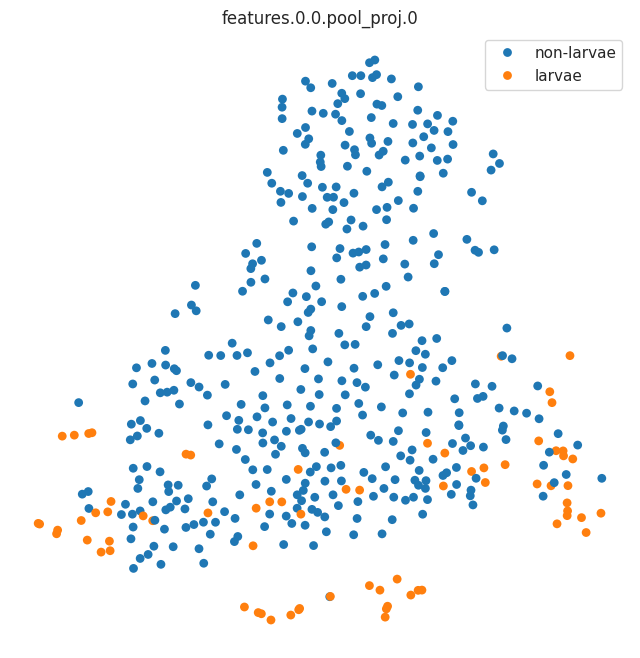

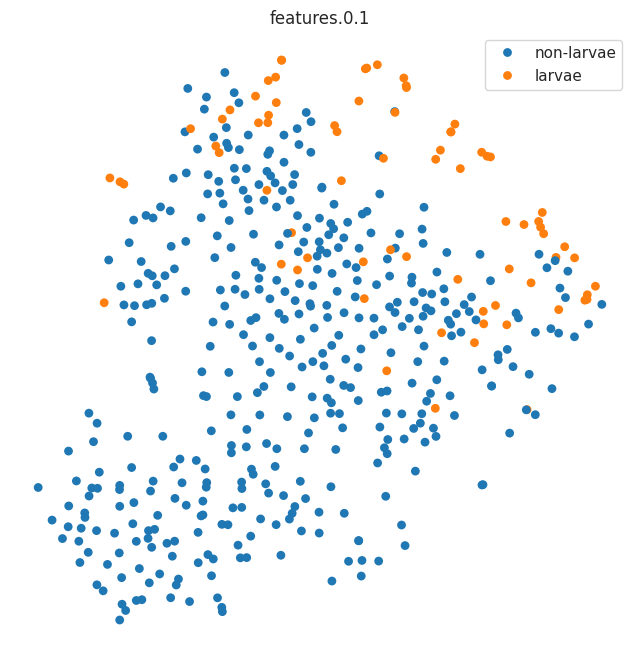

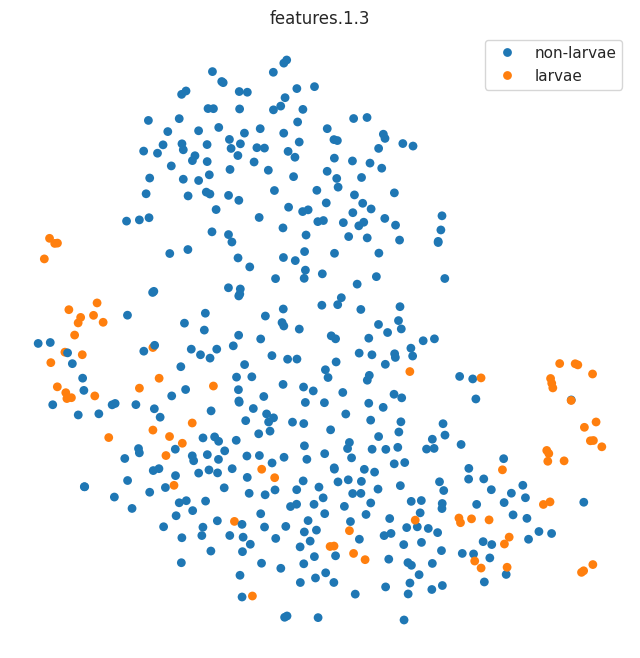

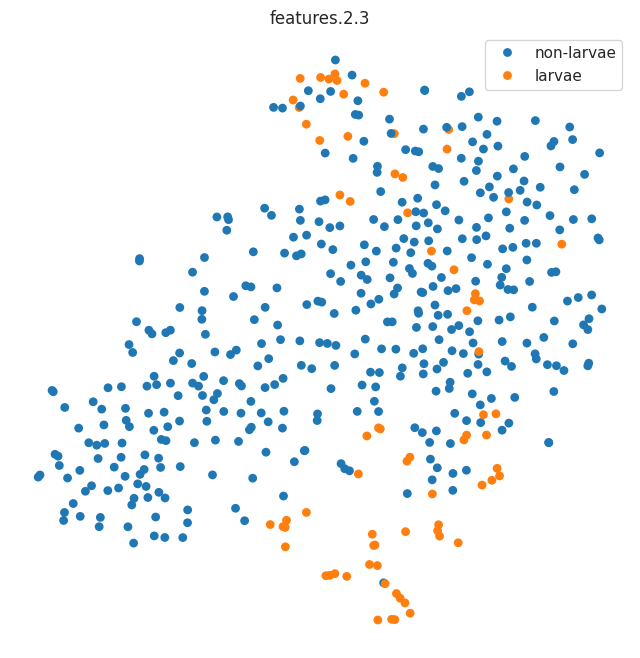

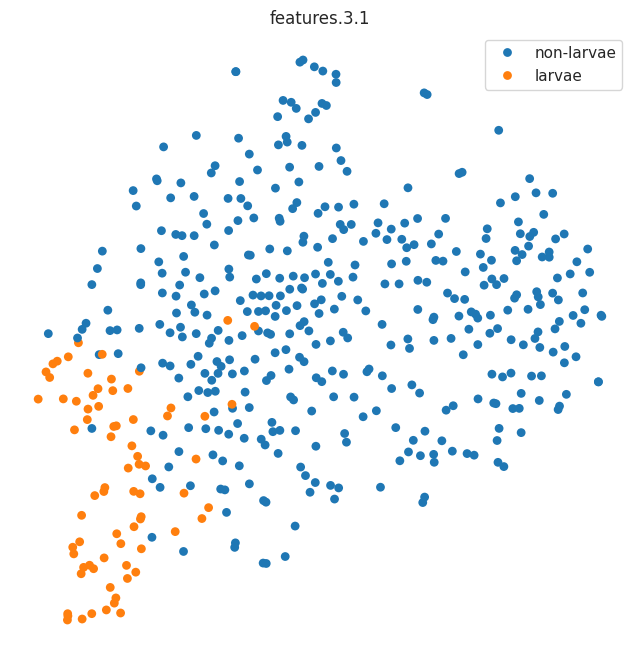

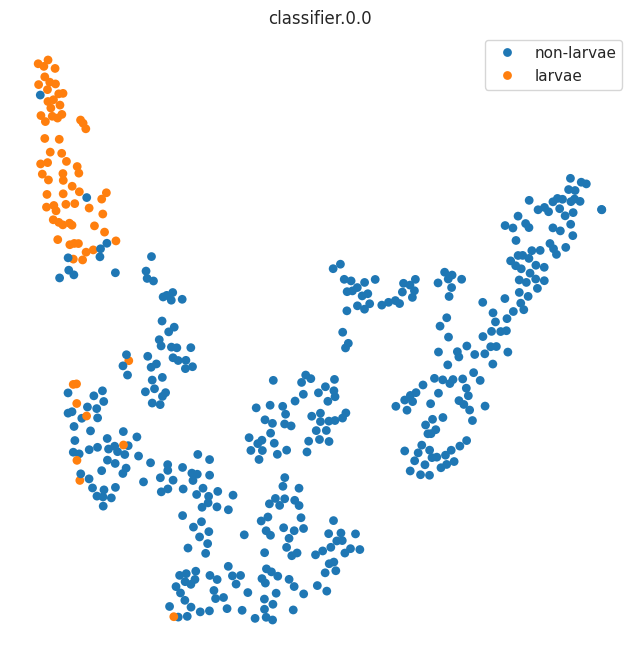

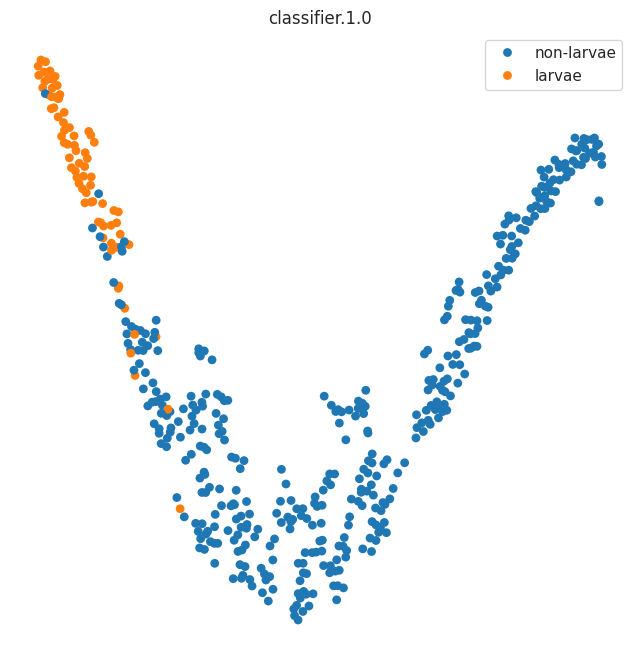

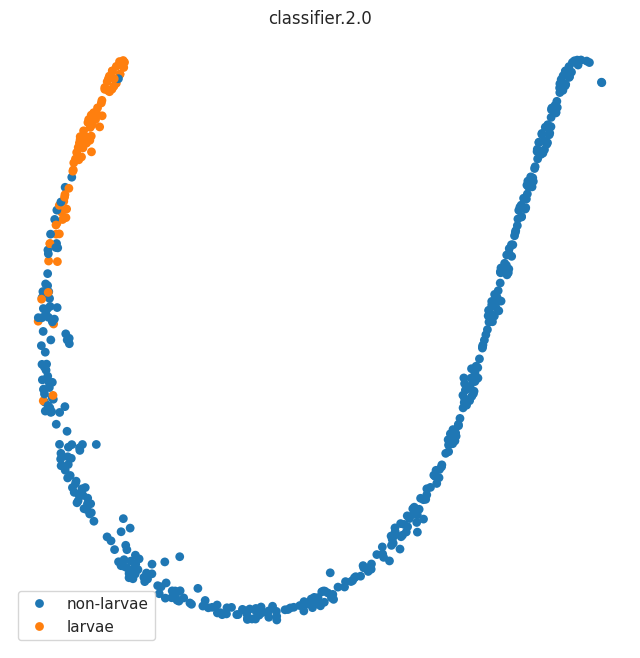

In [16]:
# Display layer representations
visualizer_0.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


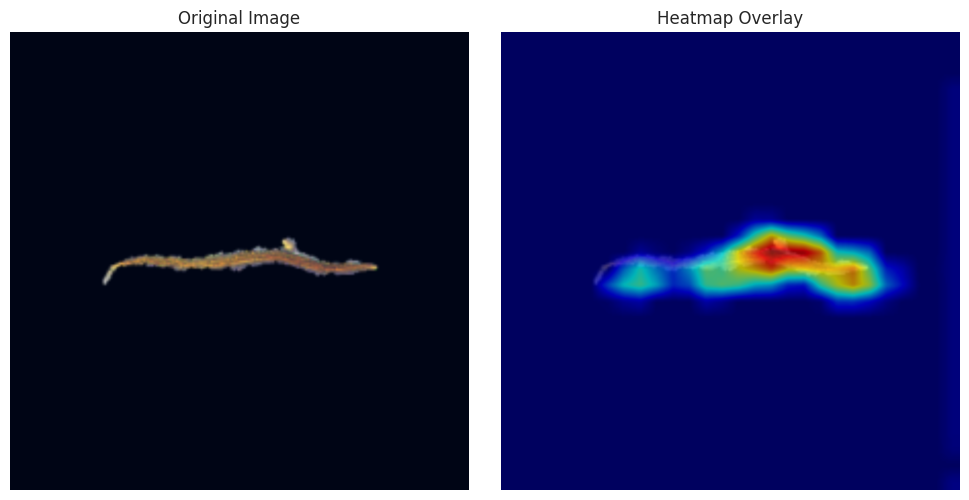

  Generating heatmap for Larvae...
  Predicted label is Larvae!


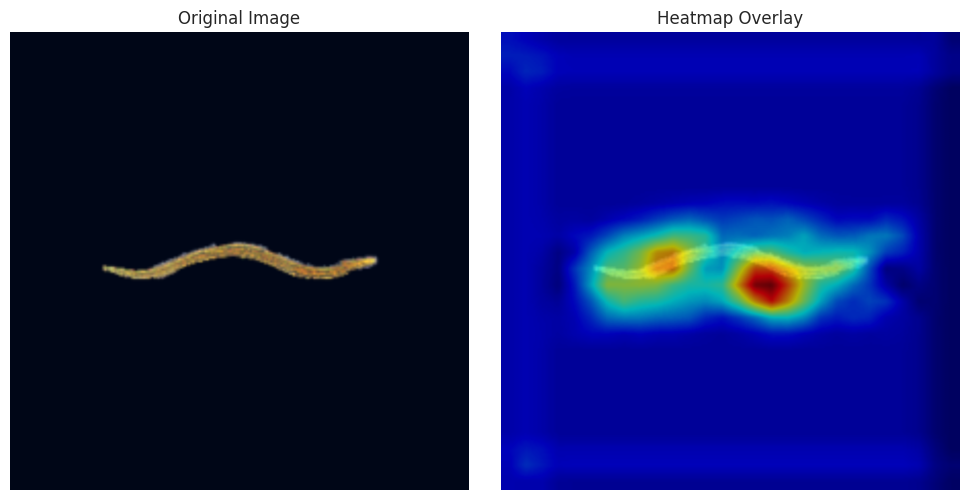

In [17]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.3. CNN1

In [18]:
cnn_1 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="inception",
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 224, 224]              16
            Conv2d-2          [-1, 4, 224, 224]              16
            Conv2d-3          [-1, 4, 224, 224]             148
            Conv2d-4          [-1, 4, 224, 224]              16
            Conv2d-5          [-1, 4, 224, 224]             404
         MaxPool2d-6          [-1, 3, 224, 224]               0
            Conv2d-7          [-1, 4, 224, 224]              16
       BatchNorm2d-8         [-1, 16, 224, 224]              32
    InceptionBlock-9         [-1, 16, 224, 224]               0
        MaxPool2d-10         [-1, 16, 112, 112]               0
           Conv2d-11          [-1, 8, 112, 112]             136
           Conv2d-12          [-1, 8, 112, 112]             136
           Conv2d-13          [-1, 8, 112, 112]             584
           Conv2d-14          [-1, 8, 1

In [19]:
optimizer_cnn_1, scheduler_cnn_1 = build_optimizer_and_scheduler(
    cnn_1,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=60,
)
ckpt_cnn_1 = "weights/larvae-adv-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [20]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=60)

📘 Epoch 1 | Train Loss: 0.6928 | Val Loss: 0.6928 | Train cohen_kappa_fn: 0.0055 | Val cohen_kappa_fn: 0.0047 | Train f1_fn: 0.0349 | Val f1_fn: 0.0292
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6910 | Val Loss: 0.6919 | Train cohen_kappa_fn: 0.0339 | Val cohen_kappa_fn: 0.0218 | Train f1_fn: 0.1855 | Val f1_fn: 0.1250
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6892 | Val Loss: 0.6894 | Train cohen_kappa_fn: 0.1144 | Val cohen_kappa_fn: 0.0877 | Train f1_fn: 0.4827 | Val f1_fn: 0.4563
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6851 | Val Loss: 0.6866 | Train cohen_kappa_fn: 0.1390 | Val cohen_kappa_fn: 0.0613 | Train f1_fn: 0.6084 | Val f1_fn: 0.5487
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6813 | Val Loss: 0.6833 | Train cohen_kappa_fn: 0.1520 | Val cohen_kappa_fn: 0.1084 | Train f1_fn: 0.8162 | Val f1_fn: 0.8180
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6734 | Val Loss: 0.6770 | Train cohen_kappa_fn: 0.2154 | Val cohen_kappa_fn: 0.0931 | Train f1_fn: 0.8460 | Val f1_fn: 0.8409
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.6670 | Val Loss: 0.6676 | Train cohen_kappa_fn: 0.3156 | Val cohen_kappa_fn: 0.0232 | Train f1_fn: 0.8958 | Val f1_fn: 0.8725
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.6625 | Val Loss: 0.6564 | Train cohen_kappa_fn: 0.3097 | Val cohen_kappa_fn: 0.2520 | Train f1_fn: 0.8494 | Val f1_fn: 0.8499
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.6448 | Val Loss: 0.6417 | Train cohen_kappa_fn: 0.3121 | Val cohen_kappa_fn: 0.2855 | Train f1_fn: 0.8429 | Val f1_fn: 0.8504
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.6290 | Val Loss: 0.6274 | Train cohen_kappa_fn: 0.3374 | Val cohen_kappa_fn: 0.2919 | Train f1_fn: 0.8621 | Val f1_fn: 0.8676
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.6123 | Val Loss: 0.6086 | Train cohen_kappa_fn: 0.3210 | Val cohen_kappa_fn: 0.3769 | Train f1_fn: 0.8454 | Val f1_fn: 0.8651
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.5920 | Val Loss: 0.5891 | Train cohen_kappa_fn: 0.3615 | Val cohen_kappa_fn: 0.3606 | Train f1_fn: 0.8331 | Val f1_fn: 0.8364
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.5732 | Val Loss: 0.5680 | Train cohen_kappa_fn: 0.3914 | Val cohen_kappa_fn: 0.4338 | Train f1_fn: 0.8720 | Val f1_fn: 0.8969
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.5666 | Val Loss: 0.5389 | Train cohen_kappa_fn: 0.3841 | Val cohen_kappa_fn: 0.4205 | Train f1_fn: 0.8259 | Val f1_fn: 0.8506
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.5344 | Val Loss: 0.5105 | Train cohen_kappa_fn: 0.3919 | Val cohen_kappa_fn: 0.3875 | Train f1_fn: 0.8286 | Val f1_fn: 0.8248
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.5074 | Val Loss: 0.4782 | Train cohen_kappa_fn: 0.4763 | Val cohen_kappa_fn: 0.5048 | Train f1_fn: 0.8819 | Val f1_fn: 0.8980
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.4877 | Val Loss: 0.4477 | Train cohen_kappa_fn: 0.4172 | Val cohen_kappa_fn: 0.4547 | Train f1_fn: 0.8377 | Val f1_fn: 0.8529
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.4354 | Val Loss: 0.4136 | Train cohen_kappa_fn: 0.5665 | Val cohen_kappa_fn: 0.6545 | Train f1_fn: 0.9143 | Val f1_fn: 0.9394
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.4158 | Val Loss: 0.3854 | Train cohen_kappa_fn: 0.4670 | Val cohen_kappa_fn: 0.5289 | Train f1_fn: 0.8640 | Val f1_fn: 0.8911
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.4058 | Val Loss: 0.3588 | Train cohen_kappa_fn: 0.5594 | Val cohen_kappa_fn: 0.5797 | Train f1_fn: 0.9003 | Val f1_fn: 0.9112
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.3599 | Val Loss: 0.3362 | Train cohen_kappa_fn: 0.6334 | Val cohen_kappa_fn: 0.6712 | Train f1_fn: 0.9286 | Val f1_fn: 0.9434
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.3405 | Val Loss: 0.3391 | Train cohen_kappa_fn: 0.4627 | Val cohen_kappa_fn: 0.4637 | Train f1_fn: 0.8552 | Val f1_fn: 0.8607
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.3332 | Val Loss: 0.3121 | Train cohen_kappa_fn: 0.5212 | Val cohen_kappa_fn: 0.5647 | Train f1_fn: 0.8805 | Val f1_fn: 0.9018
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.2998 | Val Loss: 0.3287 | Train cohen_kappa_fn: 0.4505 | Val cohen_kappa_fn: 0.4048 | Train f1_fn: 0.8447 | Val f1_fn: 0.8132
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.2839 | Val Loss: 0.2817 | Train cohen_kappa_fn: 0.5898 | Val cohen_kappa_fn: 0.6052 | Train f1_fn: 0.9066 | Val f1_fn: 0.9173
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.2968 | Val Loss: 0.3129 | Train cohen_kappa_fn: 0.4554 | Val cohen_kappa_fn: 0.4614 | Train f1_fn: 0.8501 | Val f1_fn: 0.8493
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.2734 | Val Loss: 0.2588 | Train cohen_kappa_fn: 0.6059 | Val cohen_kappa_fn: 0.6706 | Train f1_fn: 0.9129 | Val f1_fn: 0.9362
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.2399 | Val Loss: 0.2337 | Train cohen_kappa_fn: 0.6536 | Val cohen_kappa_fn: 0.7360 | Train f1_fn: 0.9284 | Val f1_fn: 0.9524
  🔥 New best model saved!


📘 Epoch 29 | Train Loss: 0.2678 | Val Loss: 0.2463 | Train cohen_kappa_fn: 0.6131 | Val cohen_kappa_fn: 0.6706 | Train f1_fn: 0.9145 | Val f1_fn: 0.9362
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.2505 | Val Loss: 0.2522 | Train cohen_kappa_fn: 0.5279 | Val cohen_kappa_fn: 0.5888 | Train f1_fn: 0.8832 | Val f1_fn: 0.9080
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.2307 | Val Loss: 0.3053 | Train cohen_kappa_fn: 0.8239 | Val cohen_kappa_fn: 0.7612 | Train f1_fn: 0.9725 | Val f1_fn: 0.9653
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.2410 | Val Loss: 0.3165 | Train cohen_kappa_fn: 0.8223 | Val cohen_kappa_fn: 0.7464 | Train f1_fn: 0.9735 | Val f1_fn: 0.9635
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.2170 | Val Loss: 0.2486 | Train cohen_kappa_fn: 0.7927 | Val cohen_kappa_fn: 0.8072 | Train f1_fn: 0.9645 | Val f1_fn: 0.9705
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


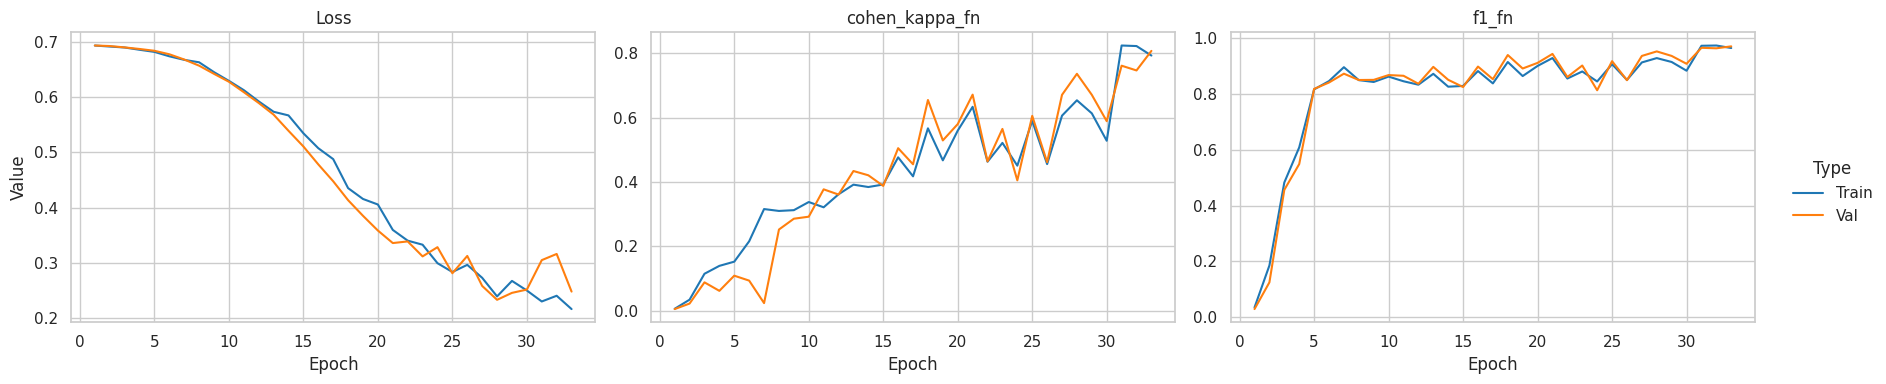

In [21]:
trainer_cnn_1.plot_epochs()

In [22]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2533 | Test cohen_kappa_fn: 0.6714 | Test f1_fn: 0.9434


#### Visualization

In [23]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

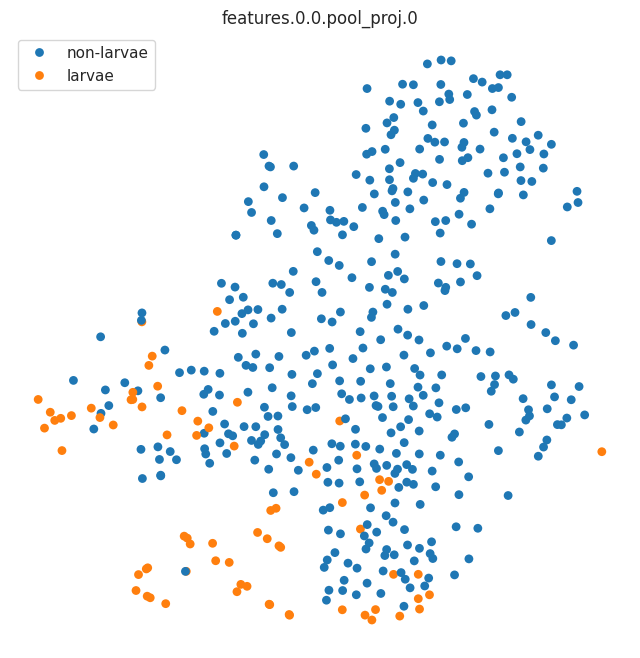

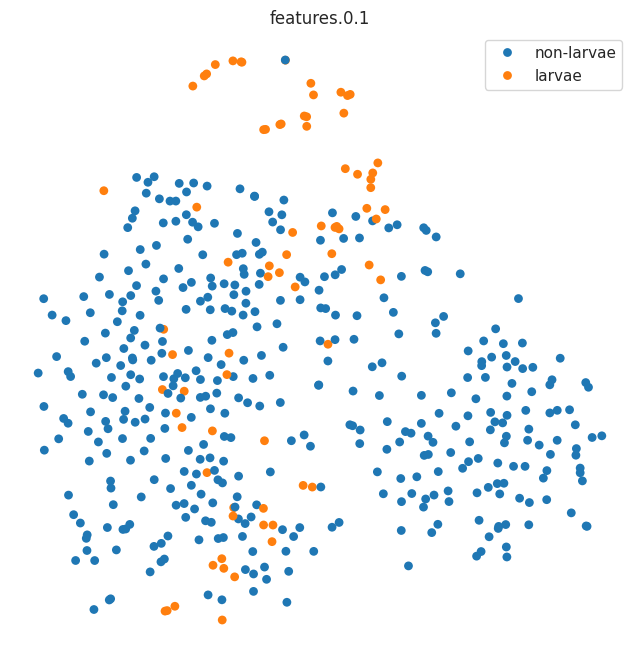

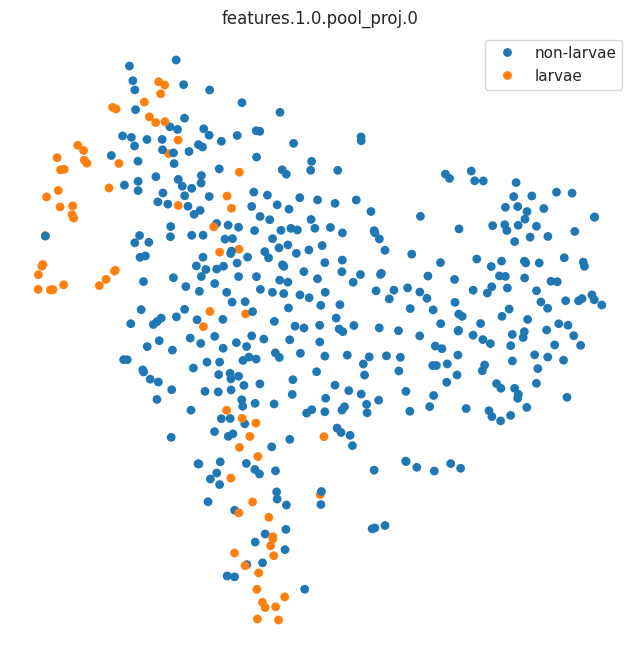

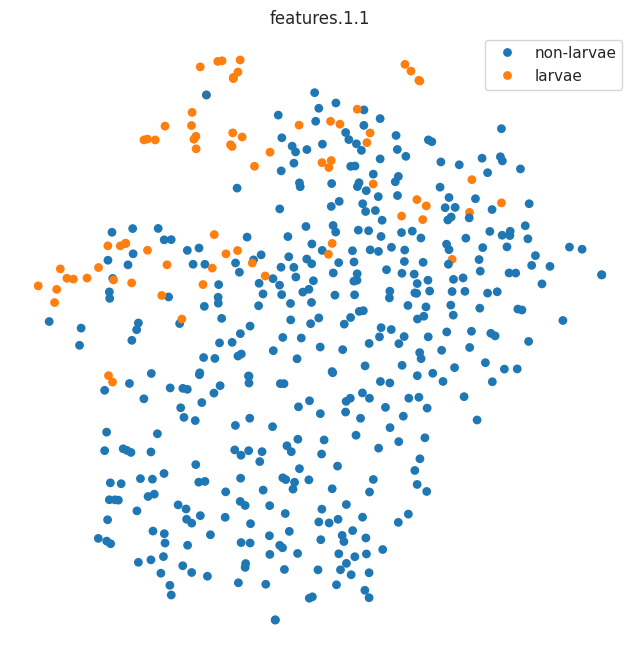

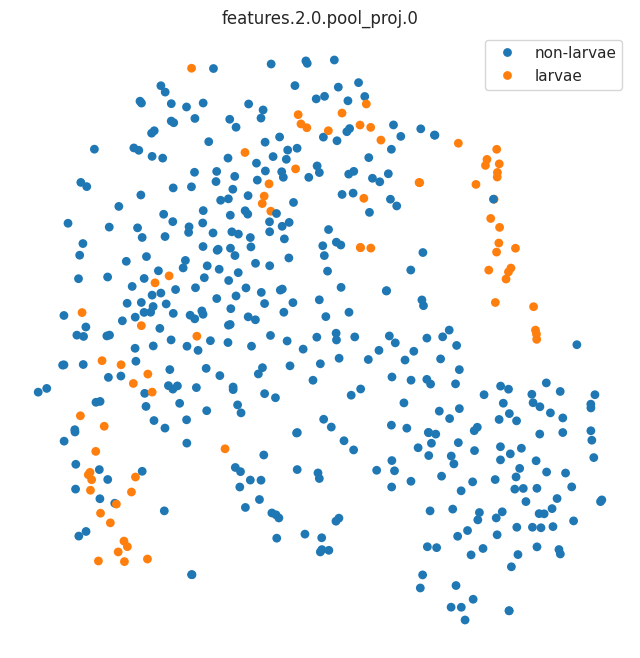

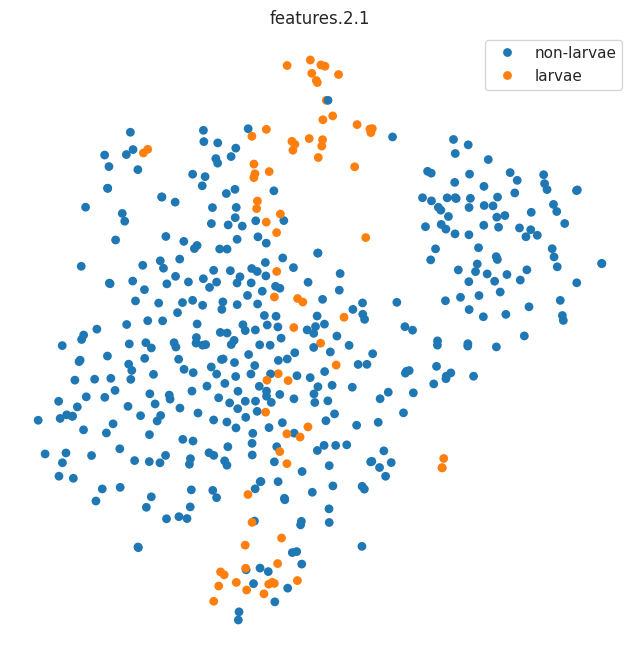

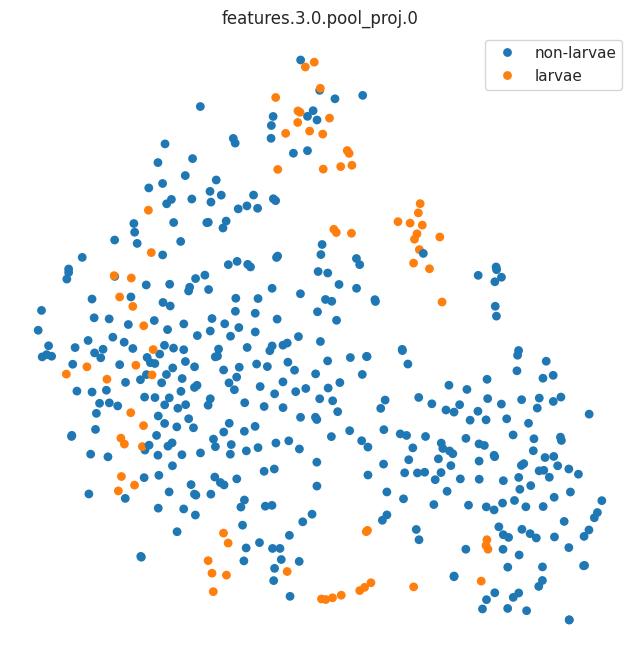

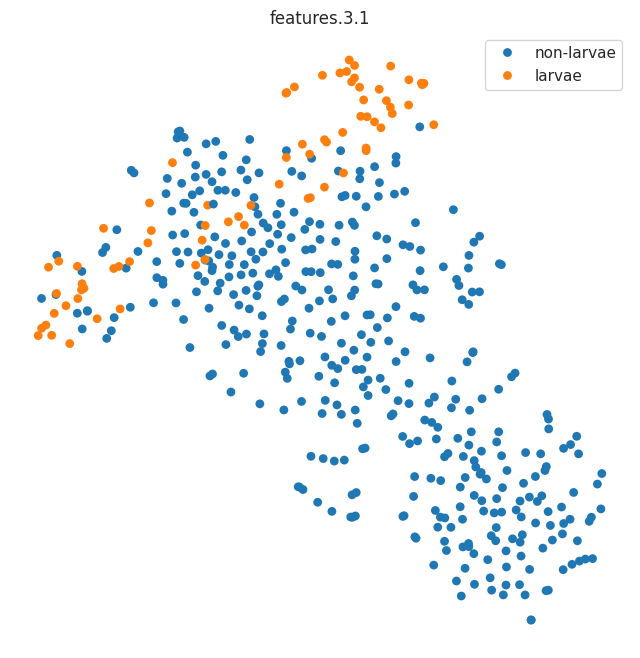

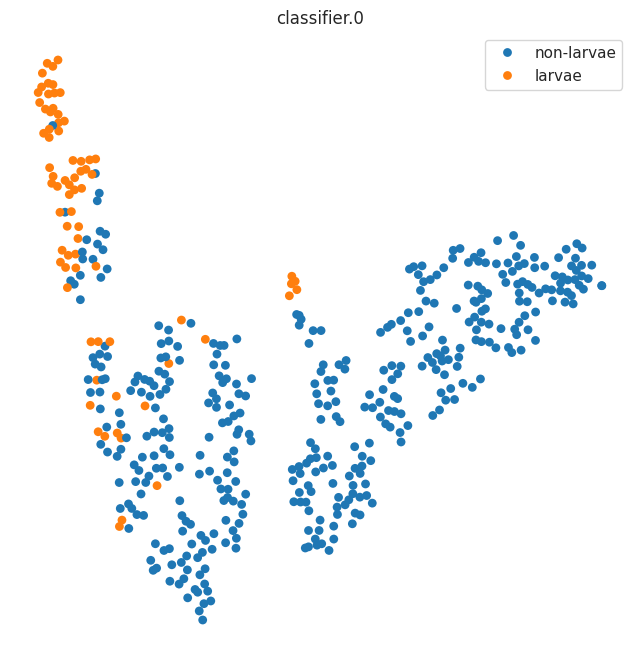

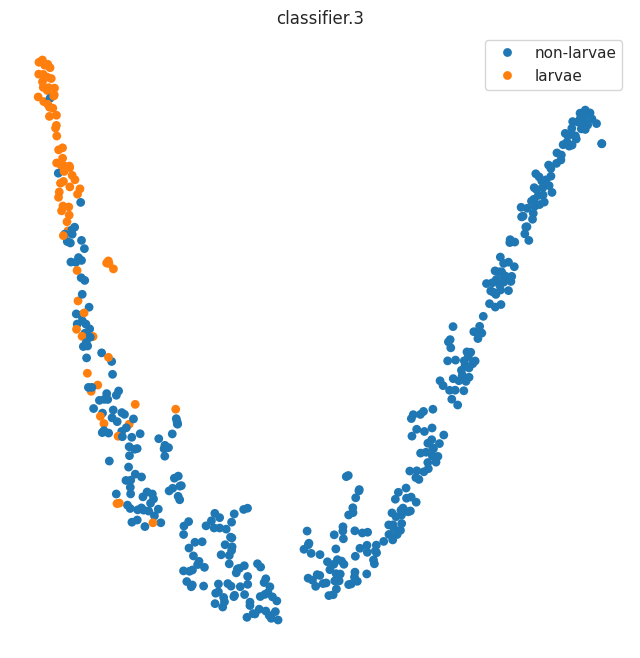

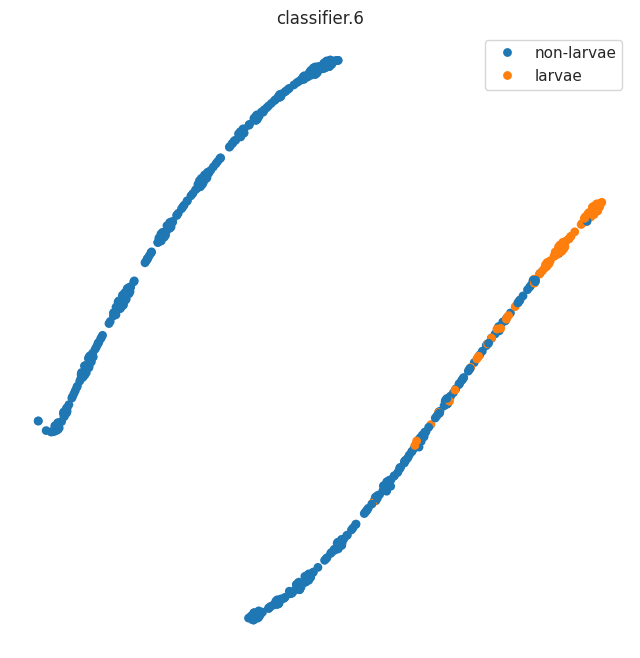

In [24]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


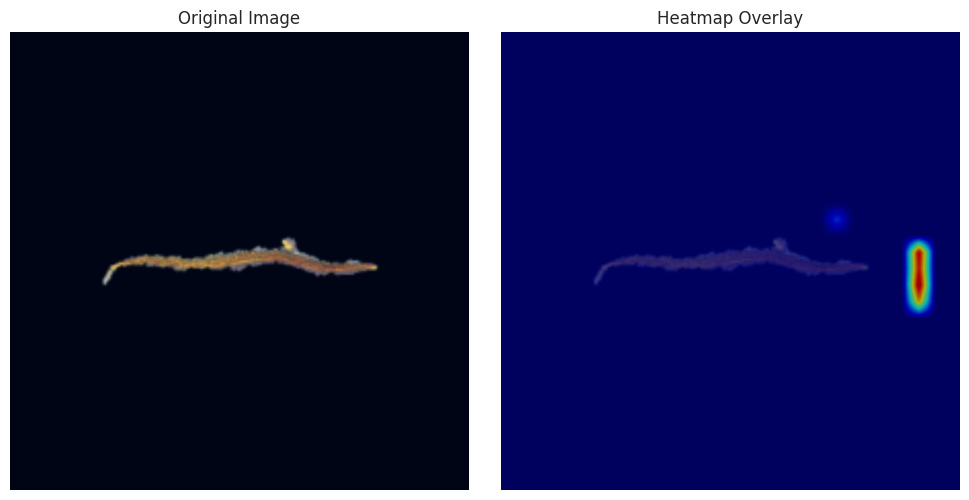

  Generating heatmap for Larvae...
  Predicted label is Larvae!


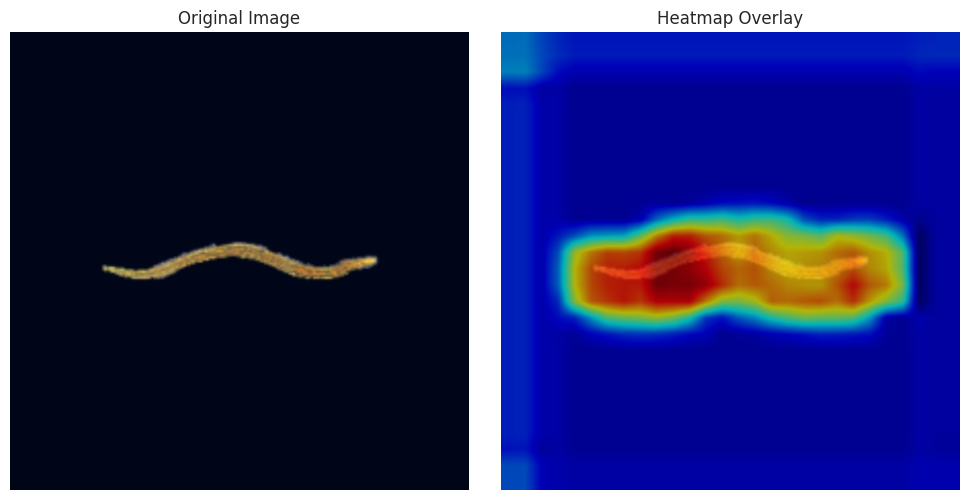

In [25]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.4. CNN2

In [26]:
cnn_2 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="se",
    device=device,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
 AdaptiveAvgPool2d-3             [-1, 16, 1, 1]               0
            Linear-4                    [-1, 1]              17
              ReLU-5                    [-1, 1]               0
            Linear-6                   [-1, 16]              32
           Sigmoid-7                   [-1, 16]               0
           SEBlock-8         [-1, 16, 224, 224]               0
         MaxPool2d-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 32, 112, 112]           4,640
             ReLU-11         [-1, 32, 112, 112]               0
AdaptiveAvgPool2d-12             [-1, 32, 1, 1]               0
           Linear-13                    [-1, 2]              66
             ReLU-14                   

In [27]:
optimizer_cnn_2, scheduler_cnn_2 = build_optimizer_and_scheduler(
    cnn_2,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=60,
)
ckpt_cnn_2 = "weights/larvae-adv-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [28]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=60)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6932 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 4 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 5 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 6 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 7 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 8 | Train Loss: 0.6932 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 9 | Train Loss: 0.6932 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 10 | Train Loss: 0.6932 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


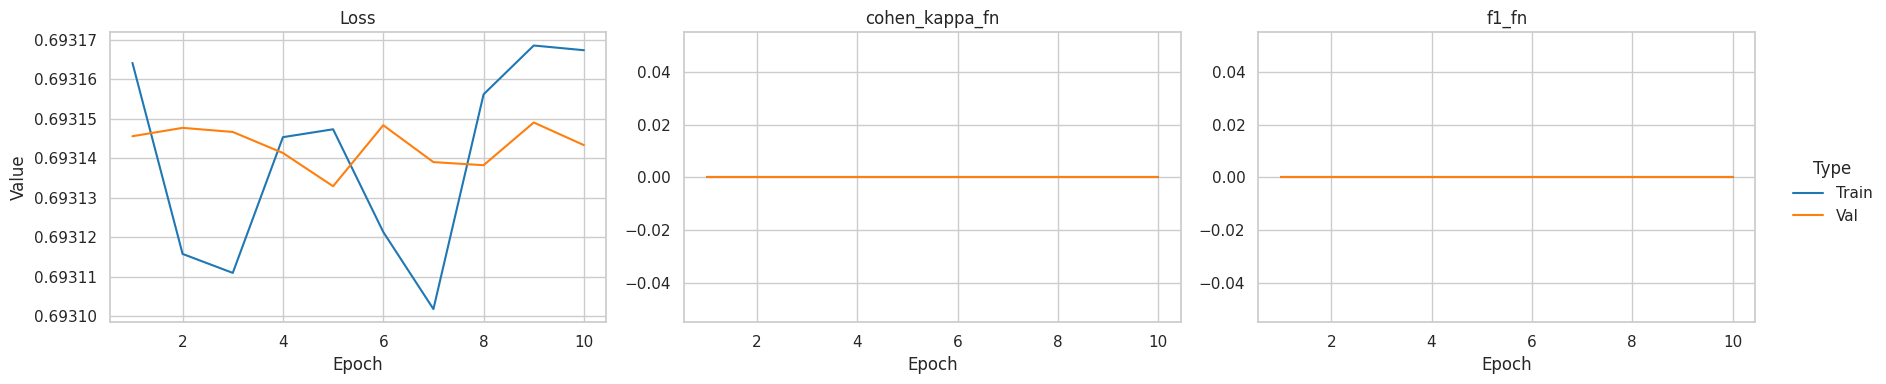

In [29]:
trainer_cnn_2.plot_epochs()

In [30]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
Test Loss: 0.6931 | Test cohen_kappa_fn: 0.0000 | Test f1_fn: 0.0000


#### Visualization

In [31]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

In [32]:
# Display layer representations
# visualizer_2.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


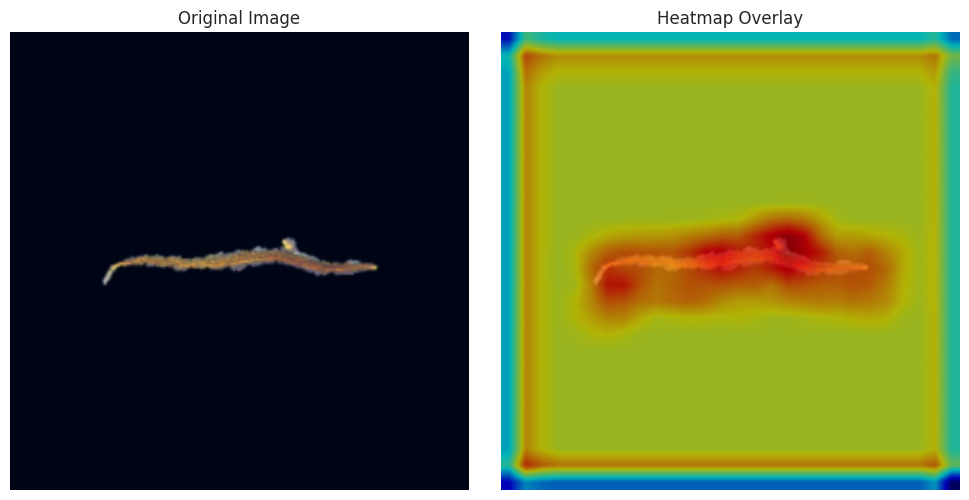

  Generating heatmap for Larvae...
  Predicted label is Non-larvae!


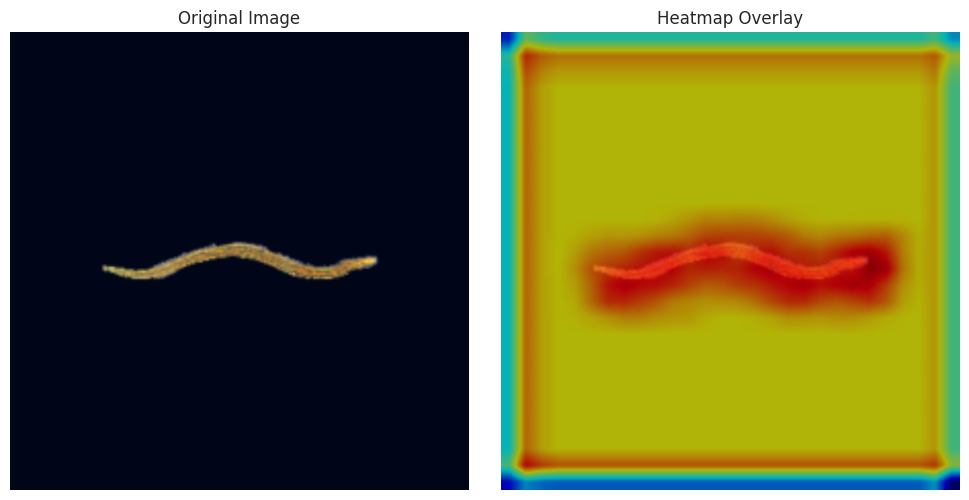

In [33]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.5. CNN3

In [34]:
cnn_3 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="cbam",
    device=device,
)
summary(cnn_3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
 AdaptiveMaxPool2d-3             [-1, 16, 1, 1]               0
 AdaptiveAvgPool2d-4             [-1, 16, 1, 1]               0
            Conv2d-5              [-1, 1, 1, 1]              16
              ReLU-6              [-1, 1, 1, 1]               0
            Conv2d-7             [-1, 16, 1, 1]              16
            Conv2d-8              [-1, 1, 1, 1]              16
              ReLU-9              [-1, 1, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]              16
          Sigmoid-11             [-1, 16, 1, 1]               0
 ChannelAttention-12             [-1, 16, 1, 1]               0
           Conv2d-13          [-1, 1, 224, 224]              99
          Sigmoid-14          [-1, 1, 2

In [35]:
cbam_optim_config = {
    "scheduler": "onecycle",
    "max_lr": 1e-3,
    "lr": 3e-4,
    "eta_min": 5e-6,
    "weight_decay": 1e-4,
    "warmup_epochs": 6,
}
optimizer_cnn_3, scheduler_cnn_3 = build_optimizer_and_scheduler(
    cnn_3,
    cbam_optim_config,
    train_loader_len=len(train_loader),
    total_epochs=60,
)
ckpt_cnn_3 = "weights/larvae-adv-cnn-3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [36]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=60)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6936 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6930 | Val Loss: 0.6929 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6929 | Val Loss: 0.6928 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 4 | Train Loss: 0.6924 | Val Loss: 0.6923 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 5 | Train Loss: 0.6917 | Val Loss: 0.6911 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6899 | Val Loss: 0.6871 | Train cohen_kappa_fn: -0.0229 | Val cohen_kappa_fn: -0.0087 | Train f1_fn: 0.8703 | Val f1_fn: 0.8858
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.6809 | Val Loss: 0.6801 | Train cohen_kappa_fn: -0.0325 | Val cohen_kappa_fn: 0.0082 | Train f1_fn: 0.9022 | Val f1_fn: 0.9094
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.6667 | Val Loss: 0.6574 | Train cohen_kappa_fn: 0.0733 | Val cohen_kappa_fn: 0.0421 | Train f1_fn: 0.7404 | Val f1_fn: 0.7474
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.6416 | Val Loss: 0.6384 | Train cohen_kappa_fn: 0.1590 | Val cohen_kappa_fn: 0.1081 | Train f1_fn: 0.6107 | Val f1_fn: 0.5765
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.6142 | Val Loss: 0.7213 | Train cohen_kappa_fn: 0.1548 | Val cohen_kappa_fn: 0.1094 | Train f1_fn: 0.7260 | Val f1_fn: 0.7489
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.5995 | Val Loss: 0.6326 | Train cohen_kappa_fn: 0.1594 | Val cohen_kappa_fn: 0.1295 | Train f1_fn: 0.5774 | Val f1_fn: 0.5602
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.6040 | Val Loss: 0.7193 | Train cohen_kappa_fn: 0.2393 | Val cohen_kappa_fn: 0.1916 | Train f1_fn: 0.7457 | Val f1_fn: 0.7754
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.5822 | Val Loss: 0.5986 | Train cohen_kappa_fn: 0.1929 | Val cohen_kappa_fn: 0.1792 | Train f1_fn: 0.6339 | Val f1_fn: 0.6386
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.5656 | Val Loss: 0.7093 | Train cohen_kappa_fn: 0.3607 | Val cohen_kappa_fn: 0.2072 | Train f1_fn: 0.9147 | Val f1_fn: 0.9244
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.5709 | Val Loss: 0.5536 | Train cohen_kappa_fn: 0.2139 | Val cohen_kappa_fn: 0.1994 | Train f1_fn: 0.6541 | Val f1_fn: 0.6650
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.5469 | Val Loss: 0.5252 | Train cohen_kappa_fn: 0.3328 | Val cohen_kappa_fn: 0.4026 | Train f1_fn: 0.7891 | Val f1_fn: 0.8495
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.4958 | Val Loss: 0.5501 | Train cohen_kappa_fn: 0.6437 | Val cohen_kappa_fn: 0.6711 | Train f1_fn: 0.9514 | Val f1_fn: 0.9590
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.4121 | Val Loss: 0.5820 | Train cohen_kappa_fn: 0.6674 | Val cohen_kappa_fn: 0.6354 | Train f1_fn: 0.9568 | Val f1_fn: 0.9556
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.4773 | Val Loss: 0.6732 | Train cohen_kappa_fn: 0.6221 | Val cohen_kappa_fn: 0.5393 | Train f1_fn: 0.9545 | Val f1_fn: 0.9472
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.4809 | Val Loss: 0.4250 | Train cohen_kappa_fn: 0.5359 | Val cohen_kappa_fn: 0.6072 | Train f1_fn: 0.8967 | Val f1_fn: 0.9272
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.4002 | Val Loss: 0.4113 | Train cohen_kappa_fn: 0.4541 | Val cohen_kappa_fn: 0.4672 | Train f1_fn: 0.8538 | Val f1_fn: 0.8689
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.3548 | Val Loss: 0.4200 | Train cohen_kappa_fn: 0.7265 | Val cohen_kappa_fn: 0.7449 | Train f1_fn: 0.9559 | Val f1_fn: 0.9613
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.3336 | Val Loss: 0.3807 | Train cohen_kappa_fn: 0.4068 | Val cohen_kappa_fn: 0.4379 | Train f1_fn: 0.8269 | Val f1_fn: 0.8518
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.3447 | Val Loss: 0.3394 | Train cohen_kappa_fn: 0.6733 | Val cohen_kappa_fn: 0.6932 | Train f1_fn: 0.9363 | Val f1_fn: 0.9472
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.2920 | Val Loss: 0.3244 | Train cohen_kappa_fn: 0.5124 | Val cohen_kappa_fn: 0.5292 | Train f1_fn: 0.8790 | Val f1_fn: 0.8938
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.3518 | Val Loss: 0.3026 | Train cohen_kappa_fn: 0.5442 | Val cohen_kappa_fn: 0.5418 | Train f1_fn: 0.8918 | Val f1_fn: 0.9008
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.2556 | Val Loss: 0.3070 | Train cohen_kappa_fn: 0.8062 | Val cohen_kappa_fn: 0.7795 | Train f1_fn: 0.9695 | Val f1_fn: 0.9669
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.2822 | Val Loss: 0.3236 | Train cohen_kappa_fn: 0.7888 | Val cohen_kappa_fn: 0.7434 | Train f1_fn: 0.9656 | Val f1_fn: 0.9591
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.2076 | Val Loss: 0.4738 | Train cohen_kappa_fn: 0.8569 | Val cohen_kappa_fn: 0.8161 | Train f1_fn: 0.9795 | Val f1_fn: 0.9746
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.2736 | Val Loss: 0.2867 | Train cohen_kappa_fn: 0.6990 | Val cohen_kappa_fn: 0.6160 | Train f1_fn: 0.9399 | Val f1_fn: 0.9243
  🔥 New best model saved!


📘 Epoch 31 | Train Loss: 0.2008 | Val Loss: 0.4098 | Train cohen_kappa_fn: 0.8398 | Val cohen_kappa_fn: 0.7339 | Train f1_fn: 0.9738 | Val f1_fn: 0.9572
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.2314 | Val Loss: 0.2689 | Train cohen_kappa_fn: 0.5503 | Val cohen_kappa_fn: 0.5785 | Train f1_fn: 0.8902 | Val f1_fn: 0.9087
  🔥 New best model saved!


📘 Epoch 33 | Train Loss: 0.2710 | Val Loss: 0.3168 | Train cohen_kappa_fn: 0.5478 | Val cohen_kappa_fn: 0.5230 | Train f1_fn: 0.8882 | Val f1_fn: 0.8889
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.2251 | Val Loss: 0.3082 | Train cohen_kappa_fn: 0.7488 | Val cohen_kappa_fn: 0.6932 | Train f1_fn: 0.9521 | Val f1_fn: 0.9472
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.1663 | Val Loss: 0.3399 | Train cohen_kappa_fn: 0.3838 | Val cohen_kappa_fn: 0.4753 | Train f1_fn: 0.8035 | Val f1_fn: 0.8595
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.2435 | Val Loss: 0.4754 | Train cohen_kappa_fn: 0.8828 | Val cohen_kappa_fn: 0.7975 | Train f1_fn: 0.9832 | Val f1_fn: 0.9730
  ❄️ No improvement, model won't be saved!


📘 Epoch 37 | Train Loss: 0.1857 | Val Loss: 0.2852 | Train cohen_kappa_fn: 0.7892 | Val cohen_kappa_fn: 0.7239 | Train f1_fn: 0.9608 | Val f1_fn: 0.9529
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


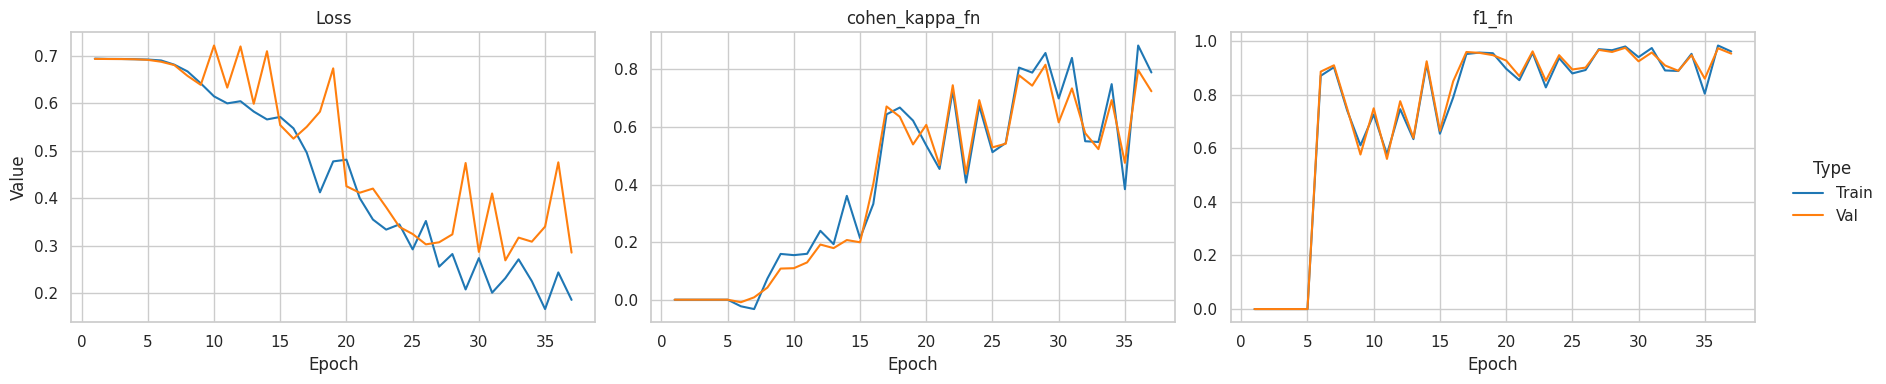

In [37]:
trainer_cnn_3.plot_epochs()

In [38]:
trainer_cnn_3.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2102 | Test cohen_kappa_fn: 0.6277 | Test f1_fn: 0.9211


#### Visualization

In [39]:
visualizer_3 = Visualizer(model=trainer_cnn_3.model, device=device, labels_map=labels_map)

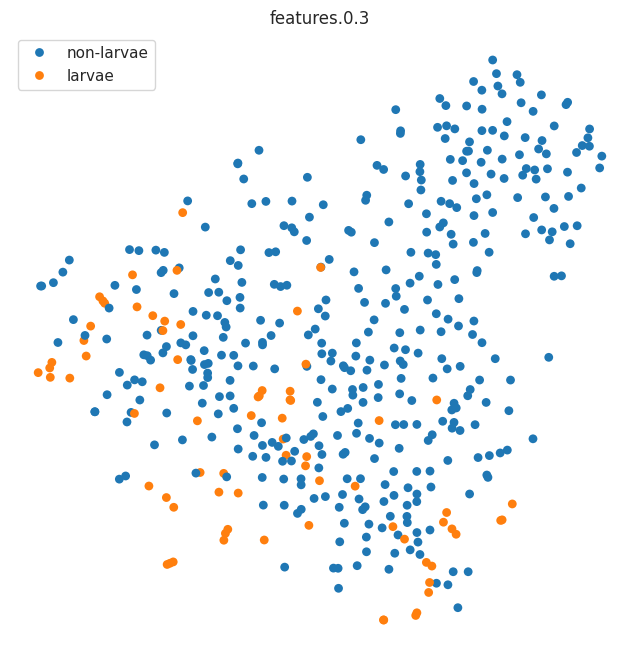

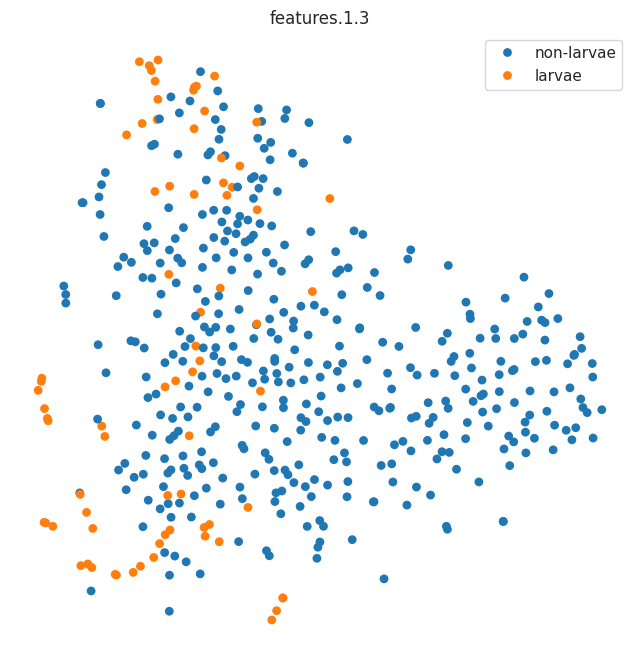

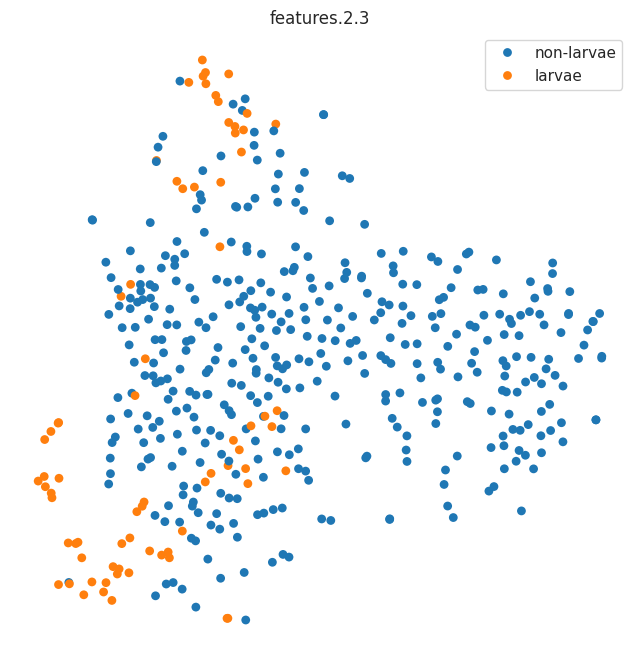

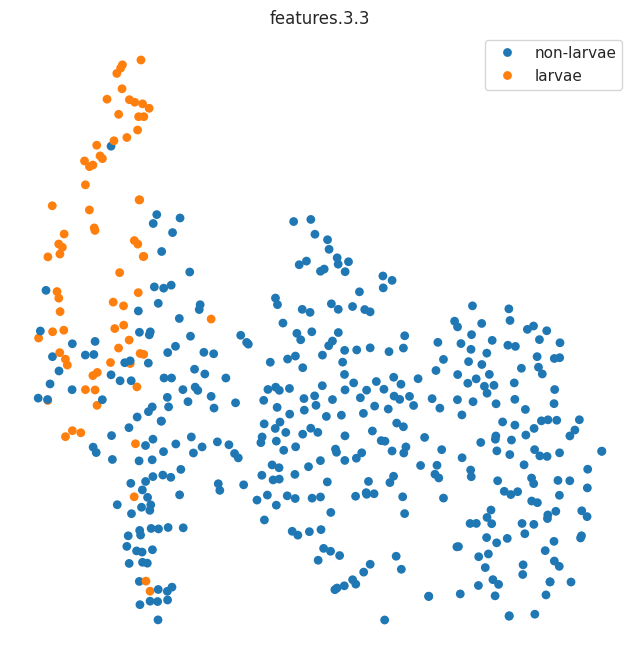

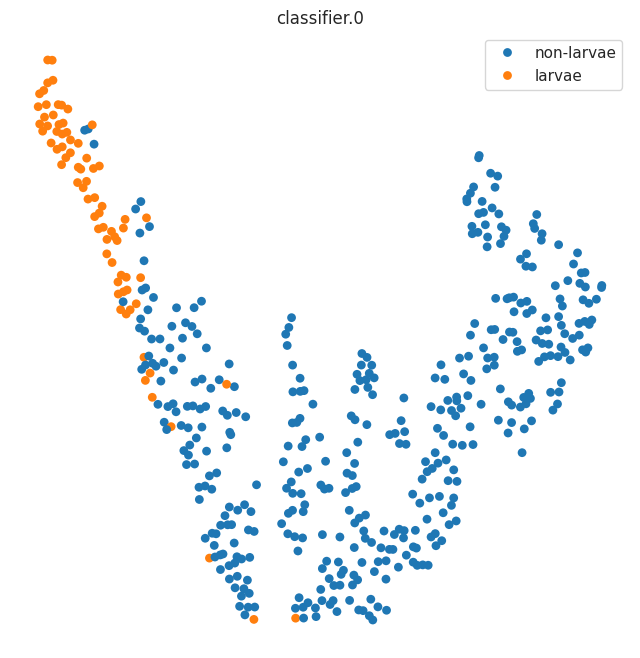

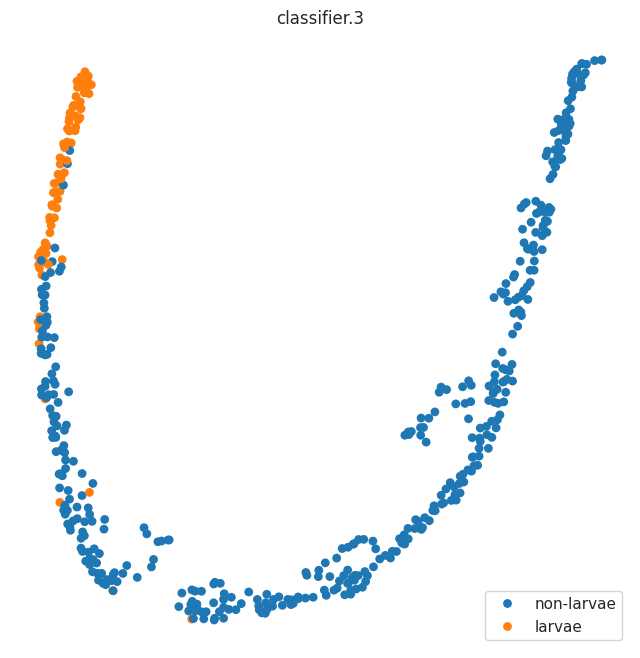

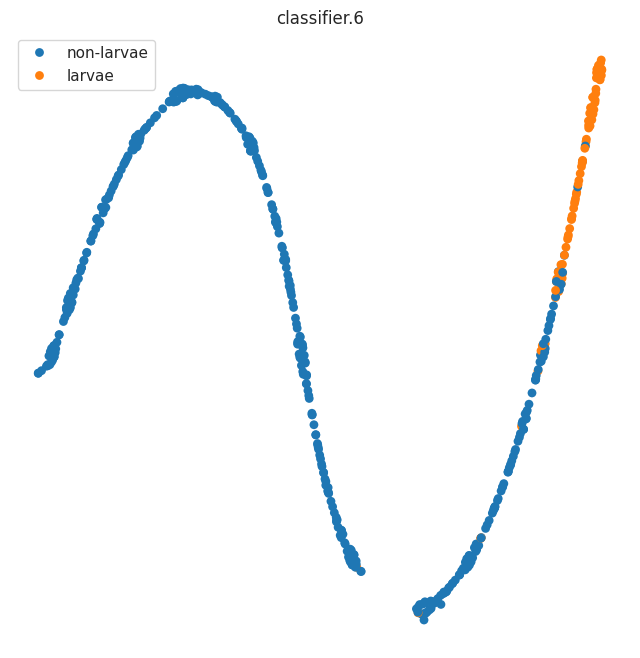

In [40]:
# Display layer representations
visualizer_3.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Larvae!


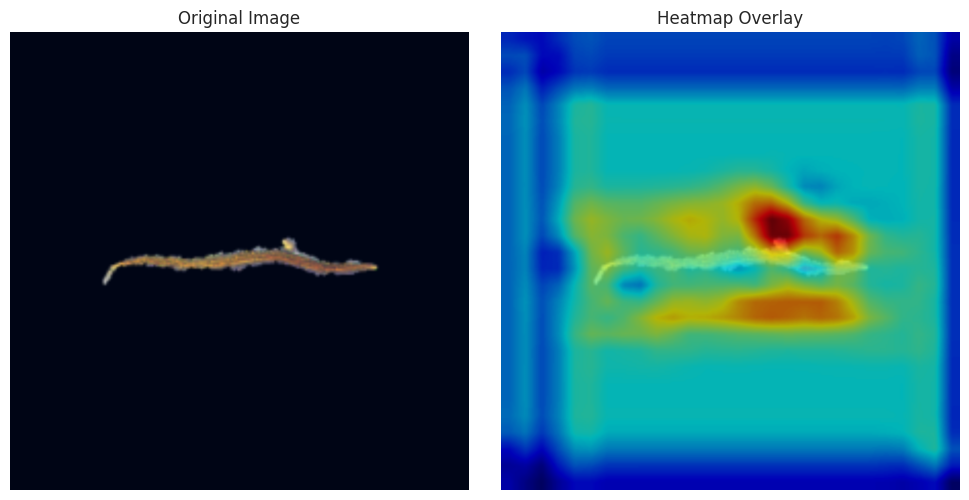

  Generating heatmap for Larvae...
  Predicted label is Larvae!


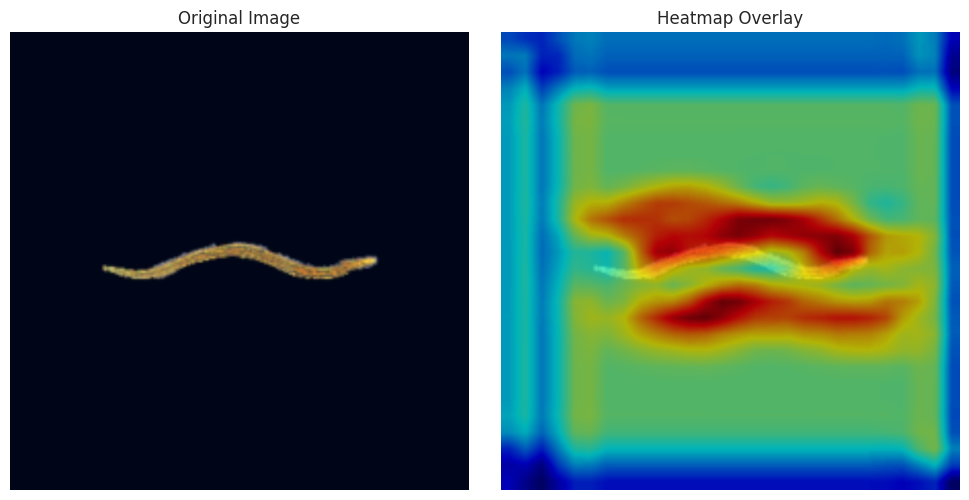

In [41]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break